In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
import pandas as pd
import matplotlib.patches as mpatches

2023-09-26 11:24:09.797434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 11:24:10.201191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 11:24:10.203256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_image = 'rgb.png'

Step1: Remove Plates and Stuff

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-09-26 11:24:13.226055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 11:24:13.325129: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


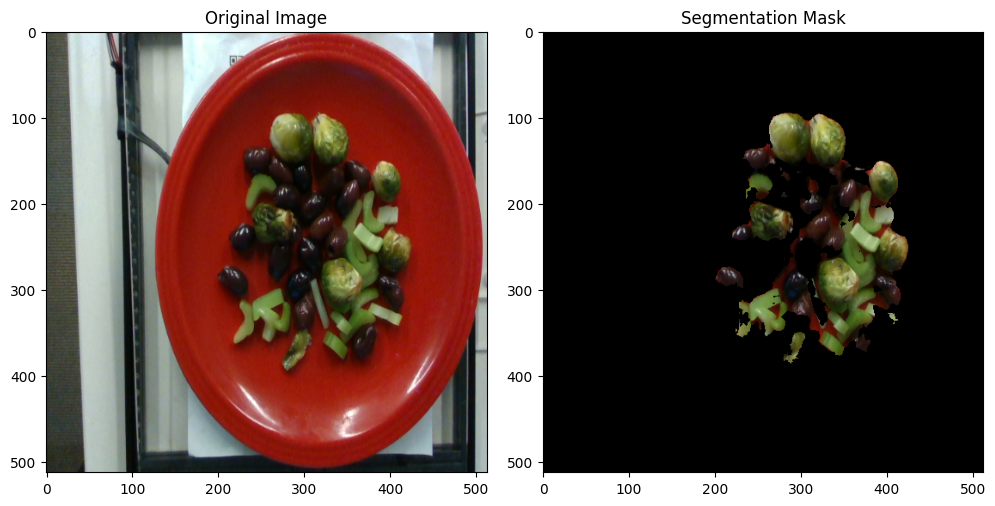

In [3]:


# Extract the tar.gz model
model_filename = 'seefood_segmenter_mobile_food_segmenter_V1_1.tar.gz'
extracted_folder_path = 'extracted_model'

if not os.path.exists(extracted_folder_path):
    with tarfile.open(model_filename, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# 1. Load the image
# image_path = 'test.jpg'
image_path = input_image
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
image = image / 255.0  # Normalize to [0, 1]

# Check if the image is 3-channel RGB
if image.shape[-1] != 3:
    print("Make sure your image is RGB.")

# Expand dimensions for batch
image_batch = tf.expand_dims(image, 0)

# 2. Load the local model with specified output keys
m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)

# 3. Use the model
results = m(image_batch)

segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

# Define the label classes to remove (adjust as needed)
classes_to_remove = [0, 23, 24]  # Example: Remove classes 2, 4, and 6

# Create a mask to remove the specified classes
mask_to_remove = np.isin(segmentation_mask, classes_to_remove)

# Apply the mask to remove the corresponding regions from the original image
image_without_classes = image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# Save the modified image without specified classes
output_image_path = 'modified_image.png'  # Specify the desired output path and filename
tf.keras.preprocessing.image.save_img(output_image_path, image_without_classes.numpy())  # Save the modified image


# 4. Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(image_without_classes.numpy())
plt.title('Segmentation Mask')

# plt.subplot(1, 3, 3)
# # Overlay the segmentation mask on the original image
# class_id = 5
# overlay = np.where(segmentation_mask == class_id, 1, 0)
# plt.imshow(image)
# plt.imshow(overlay, alpha=0.5)
# plt.title(f'Overlay (for class {class_id})')

plt.tight_layout()
plt.show()




Monocular Depth Estimation

/home/ashikh/Documents/Projects/NoticeBoard/.venv/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


[[1235.1497  1228.3162  1224.8203  ...  247.20584  220.23334  184.82487]
 [1209.4556  1220.1398  1228.636   ...  245.86679  237.10254  225.93954]
 [1209.3074  1221.1943  1229.7563  ...  245.99648  248.80739  252.96167]
 ...
 [1406.0923  1406.6954  1405.846   ... 1332.2794  1328.4308  1323.6284 ]
 [1401.7028  1403.818   1404.8649  ... 1333.607   1326.7172  1317.8347 ]
 [1393.2515  1400.0331  1402.9069  ... 1333.5878  1323.7118  1314.737  ]]


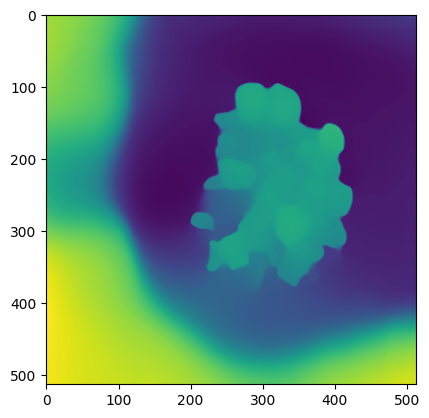

In [12]:
from PIL import Image
import numpy as np
import requests
import torch
import sys

from transformers import DPTForDepthEstimation, DPTFeatureExtractor

torch.device('cpu')

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=False)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")


image = Image.open('modified_image.png')


# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
print(output)
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
# depth.show()

depth.save("MT_Depth_UnMasked.png")
plt.imshow(depth)

Remove The Depth Mask with the original Mask

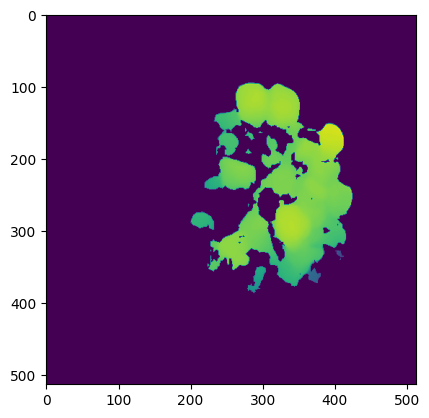

In [9]:

# Assuming you have loaded the new image as 'new_image' (similar to loading the original image)
# 1. Load the image
# image_path = 'test.jpg'
image_path = 'MT_Depth_UnMasked.png'
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
new_image = image / 255.0  # Normalize to [0, 1]


# 1. Apply the mask to the new image to remove the background
new_image_without_background = new_image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# 2. Save the new image without the background
output_new_image_path = 'MT_Depth_Masked.png'  # Specify the output path and filename
tf.keras.preprocessing.image.save_img(output_new_image_path, new_image_without_background.numpy())  # Save the new image without the background

plt.imshow(new_image_without_background)


Quantification

In [16]:
import numpy as np
import pyntcloud

from pyntcloud import PyntCloud
import cv2
import pandas as pd
from scipy.spatial import Delaunay
from stl import mesh

# Load the segmented depth image as a NumPy array
image_path = "MT_Depth_Masked.png"
# image_path = "MT_Depth_UnMasked.png"
image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
segmented_depth_image = image

print(segmented_depth_image)

# Extract depth values within the segmented food region
depth_values = segmented_depth_image[segmented_depth_image > 0]


# Assuming pixel coordinates represent (x, y) and depth represents z,
# create a 3D point cloud
height, width = segmented_depth_image.shape
y_coords, x_coords = np.where(segmented_depth_image > 0)
point_cloud = np.column_stack((x_coords, y_coords, depth_values))

# Create a PyntCloud object from the point cloud
cloud = PyntCloud(points=pd.DataFrame(point_cloud, columns=["x", "y", "z"]))

# Compute Delaunay triangulation of the 3D point cloud
triangulation = Delaunay(cloud.points.values[:, :2])  # Consider only (x, y) coordinates

# Create a mesh from the triangulation
mesh_vertices = cloud.points.values
faces = triangulation.simplices

# Calculate the volume of the mesh
mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        mesh.vectors[i][j] = mesh_vertices[f[j], :]

# Calculate the volume of the mesh
volume = mesh.get_mass_properties()[0]

# Print the estimated volume
print(f"Estimated volume of food: {volume} cubic units")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Estimated volume of food: -134473.66666666666 cubic units


Point Cloud Visualization

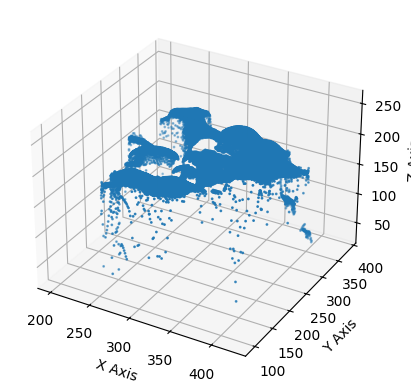

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a point cloud in the variable 'point_cloud'
# It should be a 2D NumPy array with columns for x, y, and z coordinates

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)  # 's' controls point size

# Set axis labels (customize as needed)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()


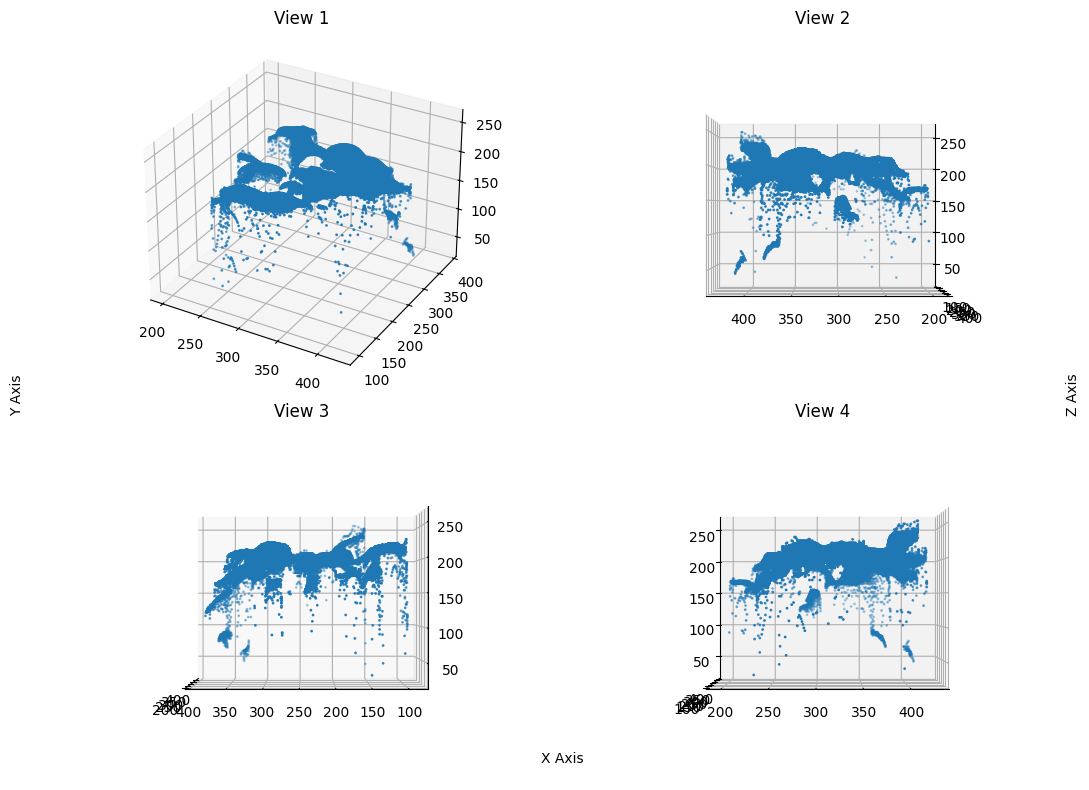

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a point cloud in the variable 'point_cloud'
# It should be a 2D NumPy array with columns for x, y, and z coordinates

# Create a figure with four subplots
fig = plt.figure(figsize=(12, 8))

# Create the first subplot (top-left)
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax1.set_title('View 1')

# Create the second subplot (top-right)
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax2.view_init(elev=0, azim=90)  # Adjust the view angle (elevation and azimuth)
ax2.set_title('View 2')

# Create the third subplot (bottom-left)
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax3.view_init(elev=0, azim=180)  # Adjust the view angle
ax3.set_title('View 3')

# Create the fourth subplot (bottom-right)
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax4.view_init(elev=0, azim=270)  # Adjust the view angle
ax4.set_title('View 4')

# Set common labels for the entire figure
fig.text(0.5, 0.04, 'X Axis', ha='center')
fig.text(0.04, 0.5, 'Y Axis', va='center', rotation='vertical')
fig.text(0.92, 0.5, 'Z Axis', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
